In [17]:
using Plots, Distributions, ColorSchemes, Statistics, Clustering, LinearAlgebra,  GeometryBasics, VoronoiCells
default(size=(800,800))

## Demandas de combustible

In [18]:
nloc=100
loc = rand(Uniform(-1,1), nloc, 2)
demandas = rand(Exponential(1),nloc);

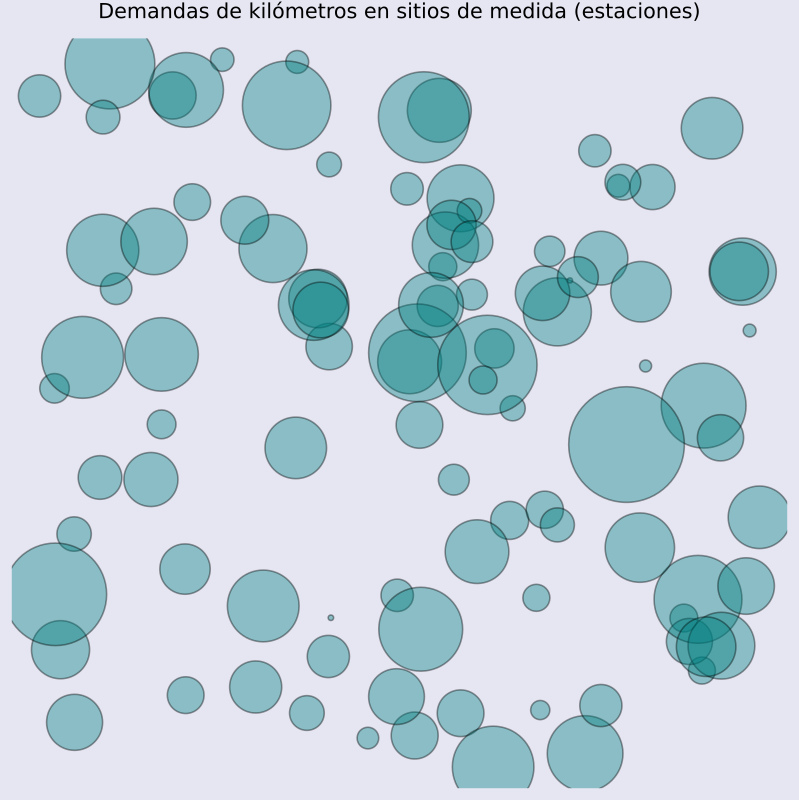

In [19]:
scatter(loc[:,1],loc[:,2], 
    markersize=30*sqrt.(demandas), 
    marker=:circle, 
    colorbar=:none,
    color=:teal,
    legend=:none, 
    markeralpha=0.4, 
    aspectratio=:equal, 
    ticks=false, 
    axis=false,
    title="Demandas de kilómetros en sitios de medida (estaciones)",
    background=RGB(0.9,0.9,0.95)
)
#savefig("demandas.png")

In [4]:
m=5
km = kmeans(loc', m, weights=demandas)
centers = km.centers'
sigma = [sqrt.(tr(cov(loc[km.assignments.==i,:]))) for i=1:m];

In [5]:
function rbf(x;weigths=[1],centers=[0,0],sigma2=[1])
    
    @assert length(w)==length(mu)==length(sigma2)>0 #chequeo consistencia de n>0
    n=length(w)

    @assert length(x)==length(mu[1]) #chequeo que los centros tengan la dim de x.
    d=length(x)

    
    kernels = [exp(-(x-mu[j])'*(x-mu[j])/sigma2[j]) for j=1:n]
    return sum(w.*kernels)
    
end

rbf (generic function with 1 method)

In [6]:
mu = [[centers[i,1],centers[i,2]] for i=1:m]
sigma2 = sigma.^2
w = ones(length(sigma2))

x1=(-1:.01:1)
x2=(-1:.01:1)

x=[[a,b] for b in x2, a in x1] ##el orden de b y a importa no entendí por qué.

z = rbf.(x, weigths=w,centers=mu,sigma2=sigma2)

heatmap(x1,x2,z,
    c=cgrad([:white, :teal]),
    axis=false, 
    ticks=false, 
    lims=(-1,1),
    colorbar=:none, 
    aspectratio=:equal, 
    legend=:none,    
    background=RGB(0.9,0.9,0.95),
    title="Ajuste por núcleos RBF")

scatter!(loc[:,1],loc[:,2], 
    markersize=30*sqrt.(demandas), 
    marker=:circle, 
    color=:gray,
    markeralpha=0.1, 
)
#savefig("ajuste.png")

"/home/andres/workspace/julia/transport_problems/Graficas INFORMS/ajuste.png"

In [7]:
function sample_rbf(N,rbf_func,xlims,ylims,cota=2.0)
    
    v=Array{Float64}(undef,N,2)
    n=0
    
    while(n<N)
        
        u1 = rand(Uniform(xlims[1],xlims[2]))
        u2 = rand(Uniform(ylims[1],ylims[2]))

        u = rand(Uniform())
        
        val  = rbf_func([u1,u2])
        
        if val/cota > u
            #accept
            n=n+1
            v[n,:] = [u1,u2]
        end
    end
    return v
end

sample_rbf (generic function with 2 methods)

In [8]:
points = sample_rbf(10000,x->rbf(x,weigths=w,centers=mu,sigma2=sigma2),(-1,1), (-1,1))
scatter(points[:,1], points[:,2], 
    aspect_ratio=:equal, 
    ticks=false, 
    axis=false, 
    lims=(-1,1), 
    label=:none, 
    ms=1,
    markerstrokewidth=0,
    background=RGB(0.9,0.9,0.95),
    title="Simulación de demanda")
#savefig("sim.png")

"/home/andres/workspace/julia/transport_problems/Graficas INFORMS/sim.png"

In [9]:
n=10
res = kmeans(points',n)
cargadores = (res.centers)';

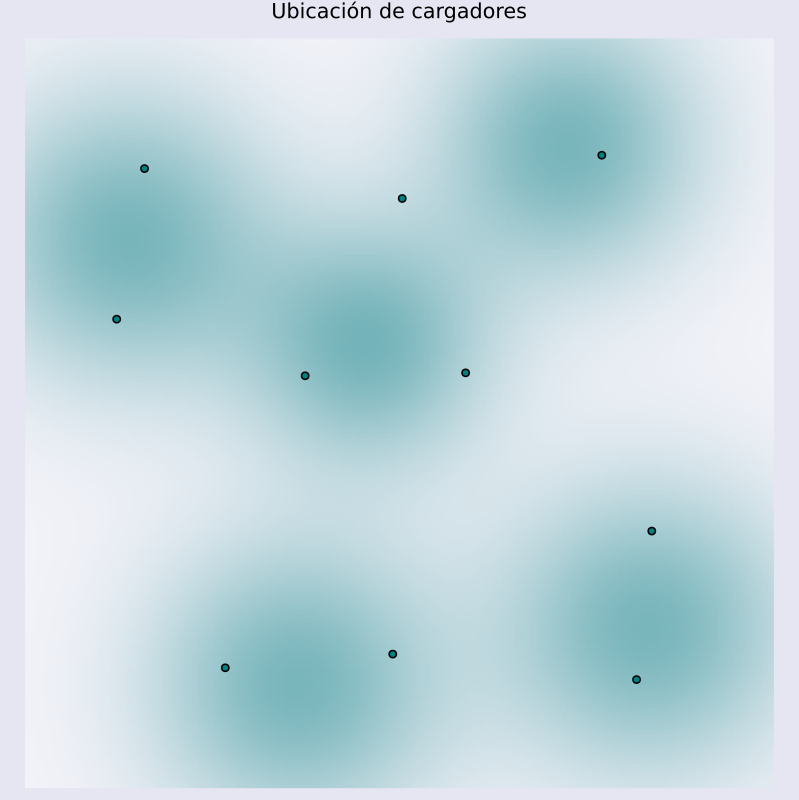

In [25]:
heatmap(x1,x2,z, 
    aspect_ratio=:equal, 
    c=c=cgrad([:white, :teal]),
    axis=false, ticks=false, lims=(-1,1),
    colorbar=:none, 
    alpha=0.5,
    background=RGB(0.9,0.9,0.95)
)

scatter!(cargadores[:,1], cargadores[:,2], legend=:none, color=:teal, title="Ubicación de cargadores")
#savefig("cargadores.png")

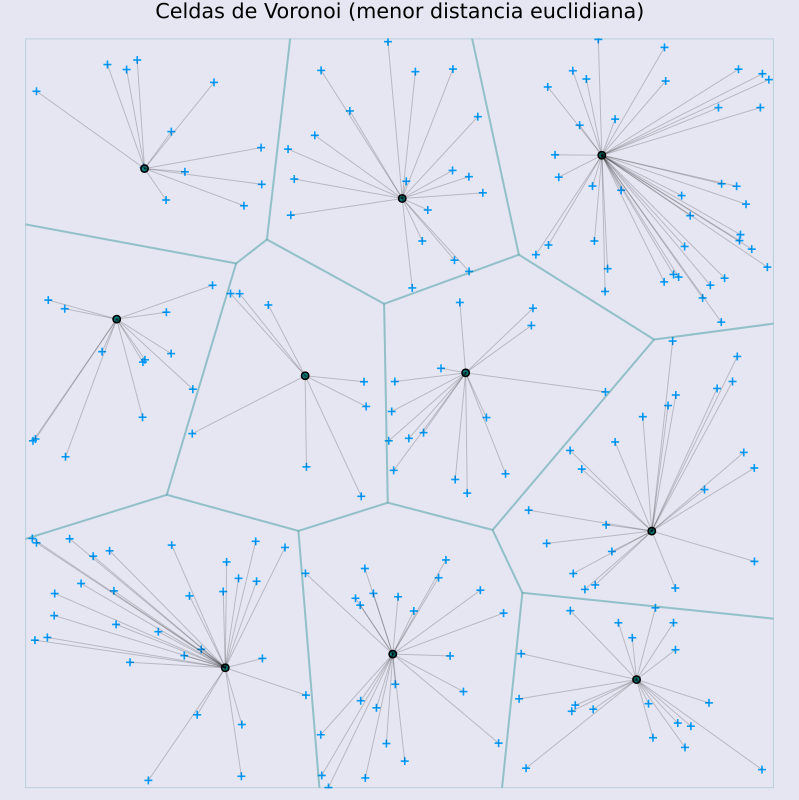

In [20]:
Na=200
Nc=n
rect = Rectangle(Point2(-1.0, -1.0), Point2(1.0, 1.0))

#autos = sample_rbf(Na,x->rbf(x,weigths=w,centers=mu,sigma2=sigma2),(-1,1), (-1,1))
autos = rand(Uniform(-1,1),Na,2)

d(x,y) = sqrt(sum((x-y).^2))
W = [d(autos[i,:],cargadores[j,:]) for i=1:Na,j=1:Nc]

attachs = zeros(Na)

for i=1:Na
    _,idx = findmin(W[i,:])
    attachs[i] = idx
end
attachs=Int64.(attachs);

X = Point2{Float64}[]
for i=1:n
    aux = Point2(cargadores[i,1],cargadores[i,2])
    push!(X,aux)
end
tess = voronoicells(X, rect);


scatter(autos[:,1],autos[:,2], xlims=(-1,1), ylims=(-1,1), aspectratio=:equal, marker=:plus)
scatter!(cargadores[:,1], cargadores[:,2], 
    legend=:none, 
    colorbar=:none, 
    background=RGB(0.9,0.9,0.95), axis=false,ticks=false,
    color=:teal,
)

for i=1:Na
    plot!([autos[i,1],cargadores[attachs[i],1]], [autos[i,2],cargadores[attachs[i],2]], color=:black, alpha=0.2)
end

plot!(tess, alpha=0.2, color=:teal, linewidth=2, title="Celdas de Voronoi (menor distancia euclidiana)")

#savefig("voronoi.png")

In [21]:
using JuMP, Ipopt

model = Model(Ipopt.Optimizer)

@variable(model,pi[1:Nc,1:Na]>=0)

con1 = @constraint(model, sum(pi,dims=2).<= 20*ones(Nc))
con2 = @constraint(model, sum(pi,dims=1).== ones(1,Na))

@objective(model,Min,sum(pi.*W'))

optimize!(model)

sol = value.(pi)

attachs=zeros(Na)
for i=1:Na 
    _,idx = findmax(sol[:,i])
    attachs[i] = idx
end

attachs = Int64.(attachs);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.0.

Number of nonzeros in equality constraint Jacobian...:     2000
Number of nonzeros in inequality constraint Jacobian.:     2000
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     2000
                     variables with only lower bounds:     2000
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      200
Total number of inequality c

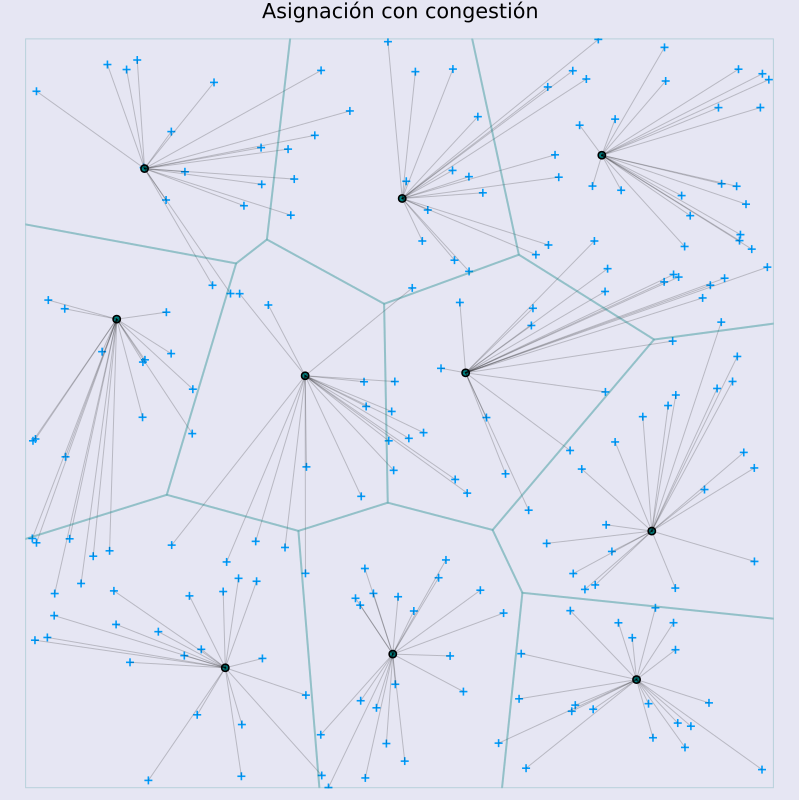

In [22]:
scatter(autos[:,1],autos[:,2], xlims=(-1,1), ylims=(-1,1), aspectratio=:equal, marker=:plus)
scatter!(cargadores[:,1], cargadores[:,2], 
    legend=:none, 
    colorbar=:none, 
    background=RGB(0.9,0.9,0.95), axis=false,ticks=false,
    color=:teal,
)

for i=1:Na
    plot!([autos[i,1],cargadores[attachs[i],1]], [autos[i,2],cargadores[attachs[i],2]], color=:black, alpha=0.2)
end
plot!(tess, alpha=0.2, color=:teal, linewidth=2, title="Celdas de Voronoi (menor distancia euclidiana)")

plot!(title="Asignación con congestión")
#savefig("congestion.png")

In [23]:
model = Model(Ipopt.Optimizer)

@variable(model,pi[1:Nc,1:Na]>=0)
@variable(model,s[1:Nc]>=0)


con1 = @constraint(model, sum(pi,dims=2).<= s)
con2 = @constraint(model, sum(pi,dims=1).== ones(1,Na))
con3 = @constraint(model, s.<= 25*ones(Nc,1))

@objective(model,Min,sum(pi.*W') + sum(s))

optimize!(model)

sol = value.(pi)

attachs=zeros(Na)
for i=1:Na 
    _,idx = findmax(sol[:,i])
    attachs[i] = idx
end

attachs = Int64.(attachs);
dual.(con1)

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.0.

Number of nonzeros in equality constraint Jacobian...:     2000
Number of nonzeros in inequality constraint Jacobian.:     2020
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     2010
                     variables with only lower bounds:     2010
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      200
Total number of inequality constraints...............:       20
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       20

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0033575e+01 1.99e+00 1.25e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

10×1 Matrix{Float64}:
 -0.9999999998038934
 -1.276483699973667
 -1.074072812342426
 -1.0000000002690999
 -0.9999999999784611
 -1.0000000001206615
 -1.0000000003031264
 -1.0294970518692428
 -1.0080333418999676
 -1.0009213391376177

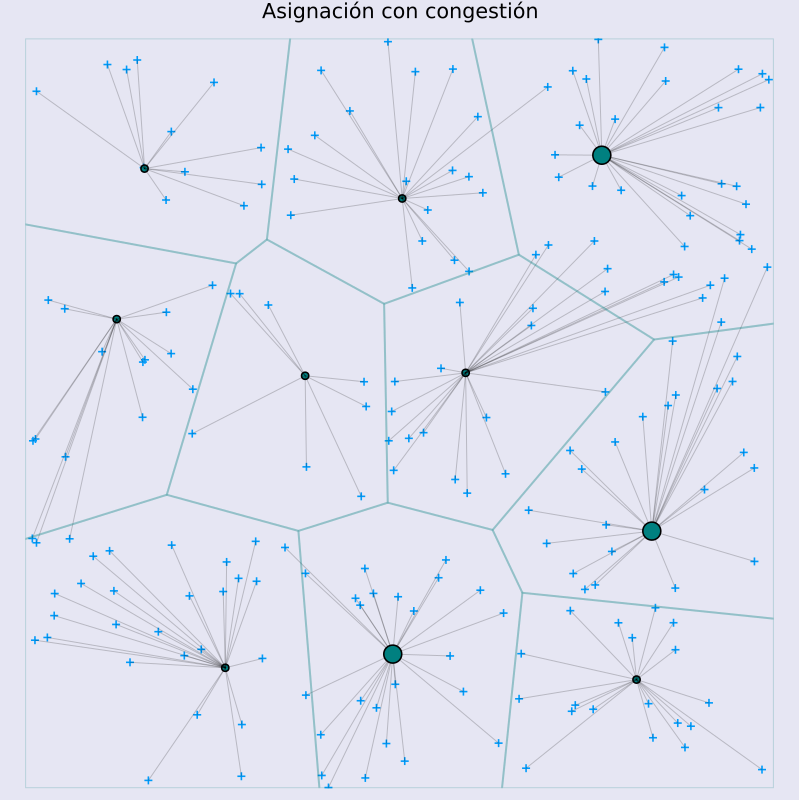

In [24]:
scatter(autos[:,1],autos[:,2], xlims=(-1,1), ylims=(-1,1), aspectratio=:equal, marker=:plus)
scatter!(cargadores[:,1], cargadores[:,2], 
    legend=:none, 
    colorbar=:none, 
    background=RGB(0.9,0.9,0.95), axis=false,ticks=false,
    color=:teal,
)

for i=1:Na
    plot!([autos[i,1],cargadores[attachs[i],1]], [autos[i,2],cargadores[attachs[i],2]], color=:black, alpha=0.2)
end
plot!(tess, alpha=0.2, color=:teal, linewidth=2, title="Celdas de Voronoi (menor distancia euclidiana)")

scatter!(cargadores[[2,8,9],1], cargadores[[2,8,9],2], 
    ms = 10,
    background=RGB(0.9,0.9,0.95), axis=false,ticks=false,
    color=:teal)

plot!(title="Asignación con congestión")
#savefig("congestion2.png")